# Step4-XGBoost

## Imports and data

In [259]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve
import wandb
import itertools
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import os
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

In [94]:
path_train="../data/milestone2/advanced_train.csv"
path_figures="../figures/milestone2/step4-xgboost/"
path_models="../models/milestone2/"
os.makedirs(path_figures, exist_ok=True)
os.makedirs(path_models, exist_ok=True)

In [95]:
df_train=pd.read_csv(path_train)
df_train.head()

,period_time_seconds,period,x_coord,y_coord,distance_from_net,shot_angle,shot_type,last_event_type,last_event_x,time_since_last_event,last_event_distance,rebound,angle_change,event_speed,is_goal
0,15,1,36.0,-23.0,57.775427,23.459024,wrist,faceoff,0.0,15.0,42.720019,False,0.000000,2.848001,0
1,20,1,63.0,0.0,26.000000,0.000000,wrist,faceoff,0.0,20.0,63.000000,False,0.000000,3.150000,1
2,154,1,-69.0,-16.0,158.808060,5.782392,wrist,shot-on-goal,79.0,33.0,148.862353,True,5.782392,4.510980,0
3,165,1,-63.0,-12.0,152.472948,4.513988,wrist,shot-on-goal,79.0,44.0,142.506140,True,4.513988,3.238776,0
4,227,1,74.0,-9.0,17.492856,30.963757,snap,shot-on-goal,79.0,106.0,10.295630,True,30.963757,0.097129,1


In [9]:
df_train.columns

Index(['period_time_seconds', 'period', 'x_coord', 'y_coord',
       'distance_from_net', 'shot_angle', 'shot_type', 'last_event_type',
       'last_event_x', 'time_since_last_event', 'last_event_distance',
       'rebound', 'angle_change', 'event_speed', 'is_goal'],
      dtype='object')

## Step 4.1 : Baseline

### train model

In [312]:
X = df_train[['distance_from_net', 'shot_angle']]
Y = df_train[["is_goal"]]

In [313]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    Y,
    test_size=0.2,      
    random_state=42
)

In [319]:
df_train["is_goal"].value_counts(normalize=True) * 100

is_goal
0    90.552537
1     9.447463
Name: proportion, dtype: float64

We divide the dataset as 80% for training and 20% for validation.

In [12]:
wandb.init(
    project="milestone_2",        
    name="xgb_model1",    
    config={
        "model": "XGBoost",
        "features": "distance and angle",
    }
)

wandb: Currently logged in as: antonios-lagarias (IFT6758_team4) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [315]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)

In [ ]:
# Default params
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
wandb.config.update(param)

In [75]:
evallist = [(dtrain, 'train'), (dval, 'val')]
num_round = 100
evals_result = {}

model1 = xgb.train(
    params=param,
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=evallist,                  
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=False
)

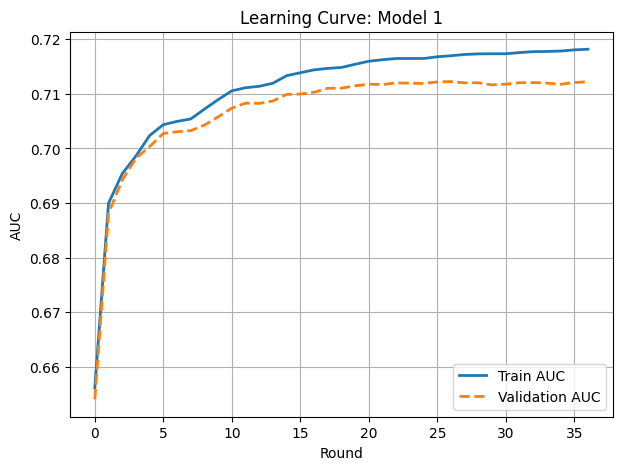

In [76]:
# Plot learning curves
train_auc = evals_result["train"]["auc"]
val_auc   = evals_result["val"]["auc"]
rounds    = np.arange(len(train_auc))

plt.figure(figsize=(7, 5))
plt.plot(rounds, train_auc, label="Train AUC", linewidth=2)
plt.plot(rounds, val_auc,   label="Validation AUC", linewidth=2, linestyle="--")
plt.xlabel("Round")
plt.ylabel("AUC")
plt.title("Learning Curve: Model 1")
plt.legend(loc="lower right")
plt.grid(True)

fig_path = path_figures + "learning_curve_model1.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

In [20]:
best_iteration = model1.best_iteration
train_auc = evals_result["train"]["auc"][best_iteration]
val_auc = evals_result["val"]["auc"][best_iteration]
print(train_auc, val_auc)

0.716980257526031 0.7122516253060908


In [21]:
wandb.log({
    "train_auc": train_auc,
    "best_iteration": best_iteration,
    "val_auc":val_auc
})

wandb.log({"learning_curve_auc": wandb.Image(fig_path)})

### figures

In [316]:
y_pred = model1.predict(dval)

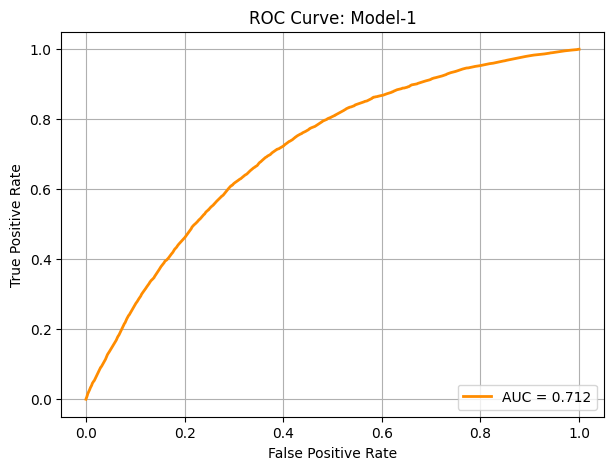

In [317]:
#Compute 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Model-1')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(path_figures+"roc_model1.png", dpi=300)
plt.show()

The ROC curve for the XGBoost model trained on only distance and angle shows an AUC of ~0.71. This indicates that the model can distinguish to some degree higher-quality shots from low-quality ones since it performs better than a random guess would (AUC=0.5).

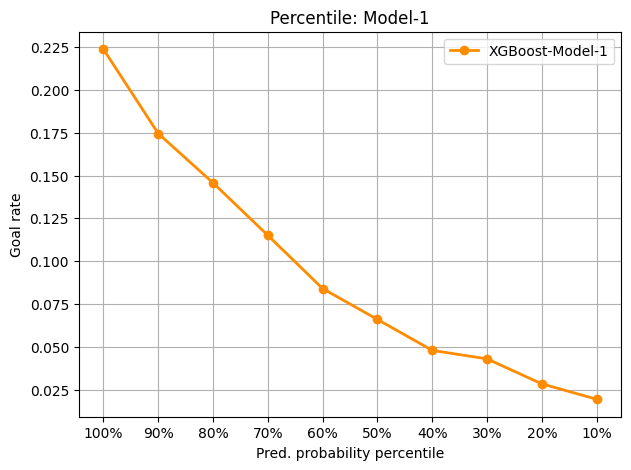

In [320]:
# prepare
df_val = pd.DataFrame({
    "y": np.asarray(y_val).ravel(),
    "p": y_pred

})

df_val["percentile_bin"] = pd.qcut(
    df_val["p"],
    q=10,                 
    labels=False
)

# compute
grouped = df_val.groupby("percentile_bin").agg(
    goal_rate=("y", "mean"),
    mean_prob=("p", "mean"),
    count=("y", "size")
).reset_index()

grouped["percentile_label"] = (grouped["percentile_bin"] + 1) * 10

# plot
plt.figure(figsize=(7, 5))
plt.plot(grouped["percentile_label"], grouped["goal_rate"],
         marker='o', color='darkorange', lw=2, label='XGBoost-Model-1')
plt.xlabel("Pred. probability percentile")
plt.ylabel("Goal rate")
plt.title("Percentile: Model-1")
plt.xticks(grouped["percentile_label"], [f"{x}%" for x in grouped["percentile_label"]])
plt.legend(loc='upper right')
plt.grid(True)
plt.gca().invert_xaxis()

# save
plt.savefig(path_figures + "percentile_model1.png", dpi=300)

plt.show()

The curve looks as expected of a correct model. The actual goal rate increases for shots in bins with higher predicted probability. For instance, among the 10% of shots the model thought were most dangerous, 22.5% were actually goals.

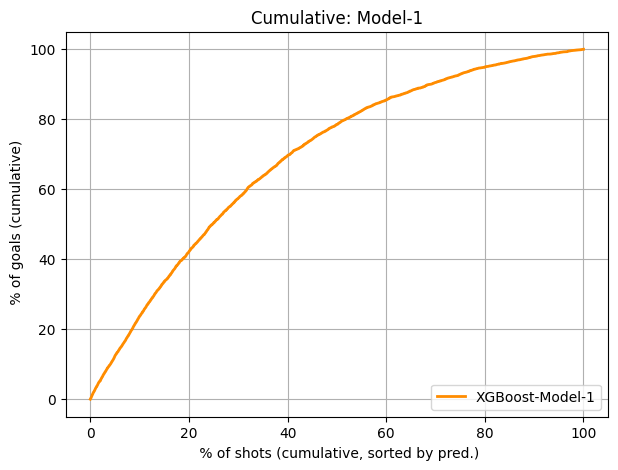

In [321]:
# prepare
df_val = df_val.sort_values("p", ascending=False).reset_index(drop=True)
df_val["cum_shots"] = np.arange(1, len(df_val) + 1)
df_val["cum_goals"] = df_val["y"].cumsum()

df_val["cum_shots_pct"] = df_val["cum_shots"] / len(df_val)
df_val["cum_goals_pct"] = df_val["cum_goals"] / df_val["y"].sum()

# plot
plt.figure(figsize=(7, 5))

plt.plot(df_val["cum_shots_pct"] * 100, df_val["cum_goals_pct"] * 100,
         color='darkorange', lw=2, label='XGBoost-Model-1')

# plot
plt.xlabel(" % of shots (cumulative, sorted by pred.)")
plt.ylabel(" % of goals (cumulative)")
plt.title("Cumulative: Model-1")
plt.legend(loc='lower right')
plt.grid(True)

# save
plt.savefig(path_figures + "cumulative_model1.png", dpi=300)

plt.show()

The top 20% of shots by predicted xG account for 40% of all goals. The top 40% of shots by predicted xG account for 75% of all goals.

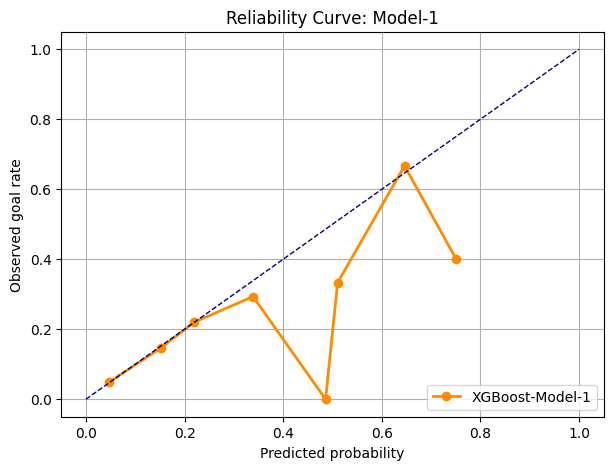

In [322]:
# compute
prob_true, prob_pred = calibration_curve(y_val, y_pred, n_bins=10)

#plot
plt.figure(figsize=(7, 5))
plt.plot(prob_pred, prob_true, marker='o', color='darkorange', lw=2, label='XGBoost-Model-1')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='')
plt.xlabel("Predicted probability")
plt.ylabel("Observed goal rate")
plt.title("Reliability Curve: Model-1")
plt.legend(loc='lower right')
plt.grid(True)

#save
plt.savefig(path_figures + "calibration_model1.png", dpi=300)
plt.show()

This is not great. Shots that the model predicted as more likely to score actually scored less often than shots with lower predicted probabilities.

In [85]:
wandb.finish()

## Step 3.2

### Model2A (only numerical data)

### train model

##### Prepare features

In [212]:
df_train["rebound"] = df_train["rebound"].astype(int)
df_train["shot_type"] = df_train["shot_type"].astype("category")
df_train["last_event_type"] = df_train["last_event_type"].astype("category")

In [213]:
df_train["last_event_type"].value_counts()

last_event_type
faceoff            84087
hit                65049
shot-on-goal       54090
blocked-shot       34498
giveaway           28287
missed-shot        28046
takeaway           19817
delayed-penalty      235
penalty              120
stoppage             110
goal                   4
period-end             1
period-start           1
Name: count, dtype: int64

In [214]:
all_features=['period_time_seconds', 'period', 'x_coord', 'y_coord',
       'distance_from_net', 'shot_angle', 'shot_type', 'last_event_type',
       'last_event_x', 'time_since_last_event', 'last_event_distance',
       'rebound', 'angle_change', 'event_speed']

cat_features=["shot_type", "last_event_type"]

##### Check missing values

In [38]:
df_train.isna().sum()

period_time_seconds         0
period                      0
x_coord                    16
y_coord                    15
distance_from_net          17
shot_angle                 17
shot_type                  30
last_event_type          2195
last_event_x             2549
time_since_last_event    2195
last_event_distance        10
rebound                     0
angle_change                4
event_speed              2205
is_goal                     0
dtype: int64

In [39]:
missing_like = ["NA", "N/A", "", "na", "NaN", "None", "null", "NULL"]
df_train.isin(missing_like).sum()[lambda x: x > 0]

Series([], dtype: int64)

In [323]:
model2A_features = [f for f in all_features if f not in cat_features]
print(model2A_features)

X = df_train[model2A_features]
Y = df_train[["is_goal"]]

['period_time_seconds', 'period', 'x_coord', 'y_coord', 'distance_from_net', 'shot_angle', 'last_event_x', 'time_since_last_event', 'last_event_distance', 'rebound', 'angle_change', 'event_speed']


In [324]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    Y,
    test_size=0.2,      
    random_state=42
)

In [325]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)

##### Optimize params with grid+cross validation

In [45]:
base_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist", 
    "nthread": 8,
    "seed": 42
}

In [46]:
max_depth_grid        = [5]
learning_rate_grid    = [0.05, 0.075, 0.1]
min_child_weight_grid = [1, 5]
subsample_grid        = [0.9, 1.0]
colsample_bytree_grid = [0.8, 0.9]

In [47]:
results = [] 

for max_depth, eta, min_child_weight, subsample, colsample_bytree in itertools.product(
    max_depth_grid,
    learning_rate_grid,
    min_child_weight_grid,
    subsample_grid,
    colsample_bytree_grid
):
    params = base_params.copy()
    params.update({
        "max_depth": max_depth,
        "eta": eta,
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree
    })
    
    cv_result = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=150,       
        nfold=5,                   
        stratified=True,
        metrics="auc",
        early_stopping_rounds=20,
        seed=42,
        verbose_eval=False
    )
    
    # best mean validation AUC and iteration
    best_auc = cv_result["test-auc-mean"].max()
    best_round = cv_result["test-auc-mean"].idxmax()
    
    results.append({
        "max_depth": max_depth,
        "eta": eta,
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "best_auc": best_auc,
        "best_round": best_round
    })

# collect
results_df = pd.DataFrame(results)

In [49]:
best_row_2A = results_df.loc[results_df["best_auc"].idxmax()]
print(best_row_2A)

max_depth             5.000000
eta                   0.050000
min_child_weight      1.000000
subsample             1.000000
colsample_bytree      0.800000
best_auc              0.733679
best_round          122.000000
Name: 2, dtype: float64


For model2A We run cross-validation with a grid of parameters three time, each time changing the values in the grid. First, a 3-fold CV gave us the best configuration as (max_depth=5, eta=0.1, min_child_weight=5, subsample=1.0, colsample_bytree=0.8) with an AUC of 0.733 (73 rounds). A second 5-fold CV gave us (max_depth=5, eta=0.05, min_child_weight=1, subsample=1.0, colsample_bytree=0.8) with nan AUC of 0.7334 (99 rounds). The thrird 5-fold CV gave us (max_depth=5, eta=0.05, min_child_weight=1, subsample=1.0, colsample_bytree=0.8) with an AUC of 0.7336 (122 rounds) which we kept for training.

In [230]:
best_params = base_params.copy()
best_params.update({
    "max_depth": int(best_row_2A["max_depth"]),
    "eta": best_row_2A["eta"],
    "min_child_weight": best_row_2A["min_child_weight"],
    "subsample": best_row_2A["subsample"],
    "colsample_bytree": best_row_2A["colsample_bytree"]
})

best_num_boost_round = int(best_row_2A["best_round"])

In [231]:
wandb.init(
    project="milestone_2", 
    name="xgb_model2A",    
    config={
        "model": "XGBoost",
        "features": "only numeric",
        ** best_params
    }
)

In [232]:
evallist = [(dtrain, 'train'), (dval, 'val')]
evals_result_2A = {}

model2A = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=best_num_boost_round,
    evals=evallist,
    evals_result=evals_result_2A,
    verbose_eval=False
)
wandb.config.update(best_params, allow_val_change=True)

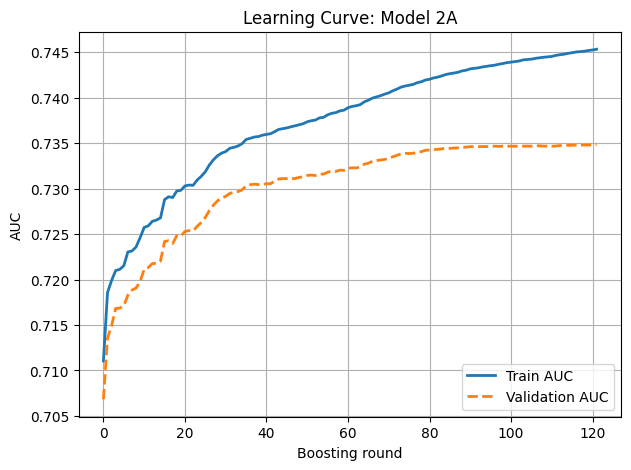

In [233]:
# compute
train_auc = evals_result_2A["train"]["auc"]
val_auc   = evals_result_2A["val"]["auc"]
rounds    = np.arange(len(train_auc))

# plot
plt.figure(figsize=(7, 5))
plt.plot(rounds, train_auc, label="Train AUC", linewidth=2)
plt.plot(rounds, val_auc,   label="Validation AUC", linewidth=2, linestyle="--")
plt.xlabel("Boosting round")
plt.ylabel("AUC")
plt.title("Learning Curve: Model 2A")
plt.legend(loc="lower right")
plt.grid(True)

# save
fig_path = path_figures + "learning_curve_model2A.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

In [234]:
num_rounds = len(evals_result_2A["train"]["auc"]) 
best_iteration = num_rounds - 1

train_auc = evals_result_2A["train"]["auc"][best_iteration]
val_auc = evals_result_2A["val"]["auc"][best_iteration]
print(train_auc)
print(val_auc)

0.7453230647115876
0.7348272152636465


In [235]:
wandb.log({
    "train_auc": train_auc,
    "best_iteration": best_iteration,
    "val_auc":val_auc
})

wandb.log({"learning_curve_auc": wandb.Image(fig_path)})

In [236]:
model_path = path_models+"model2A.ubj"
model2A.save_model(model_path)

# Create artifact
artifact = wandb.Artifact(
    name="xgboost_model2A",
    type="model",
    metadata={
        "description": "XGBoost Model 2B – includes categorical features",
        **best_params, 
        "best_auc_cv": float(best_auc),
        "best_round": int(best_iteration)
    }
)

artifact.add_file(model_path)
wandb.log_artifact(artifact)

<Artifact xgboost_model2A>

### figures

In [326]:
y_pred = model2A.predict(dval)

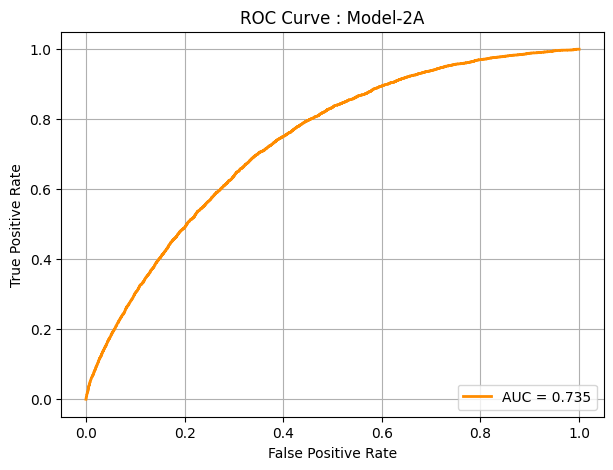

In [327]:
#compute 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
# plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve : Model-2A')
plt.legend(loc='lower right')
plt.grid(True)
#save
plt.savefig(path_figures+"roc_model2A.png", dpi=300)
plt.show()

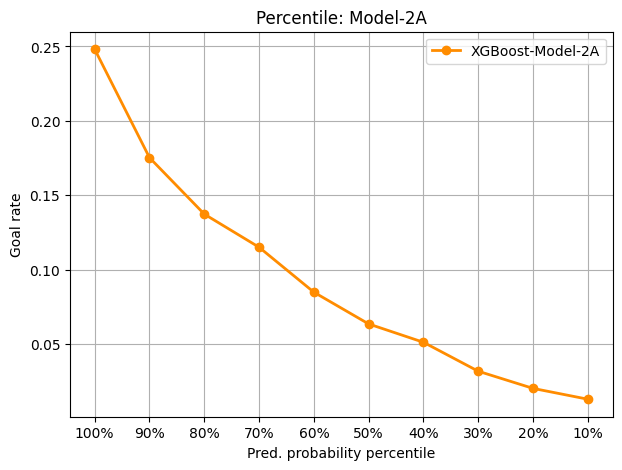

In [328]:
# compute
df_val = pd.DataFrame({
    "y": np.asarray(y_val).ravel(),
    "p": y_pred

})

df_val["percentile_bin"] = pd.qcut(
    df_val["p"],
    q=10,                 
    labels=False
)

grouped = df_val.groupby("percentile_bin").agg(
    goal_rate=("y", "mean"),
    mean_prob=("p", "mean"),
    count=("y", "size")
).reset_index()


grouped["percentile_label"] = (grouped["percentile_bin"] + 1) * 10

# plot
plt.figure(figsize=(7, 5))
plt.plot(grouped["percentile_label"], grouped["goal_rate"],
         marker='o', color='darkorange', lw=2, label='XGBoost-Model-2A')
plt.xlabel("Pred. probability percentile")
plt.ylabel("Goal rate")
plt.title("Percentile: Model-2A")
plt.xticks(grouped["percentile_label"], [f"{x}%" for x in grouped["percentile_label"]])
plt.legend(loc='upper right')
plt.grid(True)
plt.gca().invert_xaxis()

#save
plt.savefig(path_figures + "percentile_model2A.png", dpi=300)

plt.show()

The curve looks as expected of a correct model. The actual goal rate increases for shots in bins with higher predicted probability. For instance, among the 10% of shots the model thought were most dangerous, 25% were actually goals. This is an improvement to the baseline model.

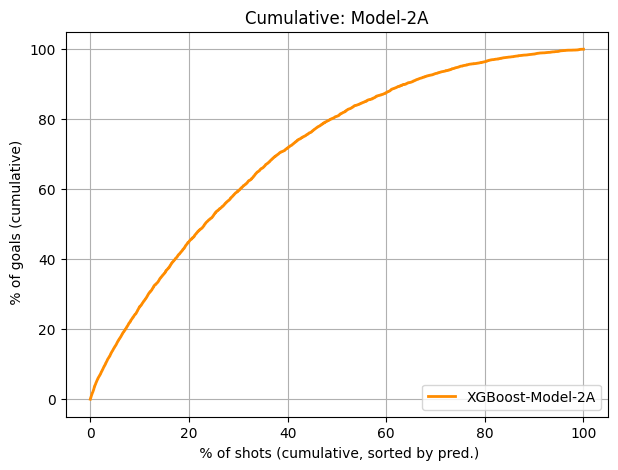

In [329]:
#compute
df_val = df_val.sort_values("p", ascending=False).reset_index(drop=True)
df_val["cum_shots"] = np.arange(1, len(df_val) + 1)
df_val["cum_goals"] = df_val["y"].cumsum()

df_val["cum_shots_pct"] = df_val["cum_shots"] / len(df_val)
df_val["cum_goals_pct"] = df_val["cum_goals"] / df_val["y"].sum()

#plot
plt.figure(figsize=(7, 5))


plt.plot(df_val["cum_shots_pct"] * 100, df_val["cum_goals_pct"] * 100,
         color='darkorange', lw=2, label='XGBoost-Model-2A')

plt.xlabel(" % of shots (cumulative, sorted by pred.)")
plt.ylabel(" % of goals (cumulative)")
plt.title("Cumulative: Model-2A")
plt.legend(loc='lower right')
plt.grid(True)

#save
plt.savefig(path_figures + "cumulative_model2A.png", dpi=300)

plt.show()

The top 20% of shots by predicted by XG account for 45% of all goals. The top 40% of shots by predicted xG account for 75% of all goals. This is a slight increase to the baseline model.

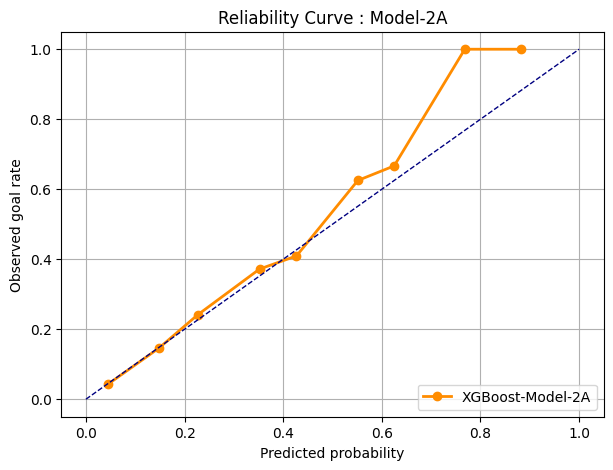

In [330]:
#compute
prob_true, prob_pred = calibration_curve(y_val, y_pred, n_bins=10)
#plot
plt.figure(figsize=(7, 5))
plt.plot(prob_pred, prob_true, marker='o', color='darkorange', lw=2, label='XGBoost-Model-2A')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='')
plt.xlabel("Predicted probability")
plt.ylabel("Observed goal rate")
plt.title("Reliability Curve : Model-2A")
plt.legend(loc='lower right')
plt.grid(True)
#save
plt.savefig(path_figures + "calibration_model2A.png", dpi=300)

plt.show()

This is a significantly better performance compared to the baseline model. We see an issue the in the shots with highest probablity, where the actual goal rate is higher than the predicted propabilities.

In [237]:
wandb.finish()

best_iteration,▁
train_auc,▁
val_auc,▁
best_iteration,121
train_auc,0.74532
val_auc,0.73483


### Model 2B (includes categorical features)

In [245]:
# Drop outlier categories
counts = df_train["last_event_type"].value_counts()
print(counts)
df_train_filter = df_train[df_train["last_event_type"].isin(counts[counts >= 100].index)]

last_event_type
faceoff            84087
hit                65049
shot-on-goal       54090
blocked-shot       34498
giveaway           28287
missed-shot        28046
takeaway           19817
delayed-penalty      235
penalty              120
stoppage             110
goal                   4
period-end             1
period-start           1
Name: count, dtype: int64


**Underpresented categories for last_event_type**\
XGBoost classification is not very sensitive to outliers so for now we kept the full data as it is. For this step however checked the two categorical features to see if all categories are well represented in our data. We observed that in *last_event_type* five categories have between 1 and 250 observations while the others have over 19000. For the final model-2B we excluded the three categories with less than 5 observations that seemed to be errors or noise.

In [331]:
X = df_train_filter[all_features]
Y = df_train_filter[["is_goal"]]

In [332]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    Y,
    test_size=0.2,      
    random_state=42
)

In [333]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True) 
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

In [167]:
max_depth_grid        = [5]
learning_rate_grid    = [0.05, 0.075, 0.1]
min_child_weight_grid = [1, 5]
subsample_grid        = [0.9, 1.0]
colsample_bytree_grid = [0.8, 0.9]

In [168]:
results = []

for max_depth, eta, min_child_weight, subsample, colsample_bytree in itertools.product(
    max_depth_grid,
    learning_rate_grid,
    min_child_weight_grid,
    subsample_grid,
    colsample_bytree_grid
):
    params = base_params.copy()
    params.update({
        "max_depth": max_depth,
        "eta": eta,
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree
    })
    
    cv_result = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=150,       # max trees to try
        nfold=5,                   # 5-fold CV
        stratified=True,
        metrics="auc",
        early_stopping_rounds=20,
        seed=42,
        verbose_eval=False
    )
    
    # Best mean validation AUC and the iteration where it happened
    best_auc = cv_result["test-auc-mean"].max()
    best_round = cv_result["test-auc-mean"].idxmax()
    
    results.append({
        "max_depth": max_depth,
        "eta": eta,
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "best_auc": best_auc,
        "best_round": best_round
    })

# Collect everything in a DataFrame for analysis/plots
results_df = pd.DataFrame(results)

In [169]:
best_row_2B = results_df.loc[results_df["best_auc"].idxmax()]
print(best_row_2B)

max_depth             5.000000
eta                   0.075000
min_child_weight      5.000000
subsample             1.000000
colsample_bytree      0.900000
best_auc              0.739398
best_round          149.000000
Name: 15, dtype: float64


For model2B we started from the previous best parameters, and adjusted the grid to see if there is any change. We run a single cross-validation that gave us the best configuration as (max_depth=5, eta=0.75, min_child_weight=1, subsample=0.9, colsample_bytree=0.8) with an AUC of 0.733 (140 rounds).

In [170]:
best_params = base_params.copy()
best_params.update({
    "max_depth": int(best_row_2B["max_depth"]),
    "eta": best_row_2B["eta"],
    "min_child_weight": best_row_2B["min_child_weight"],
    "subsample": best_row_2B["subsample"],
    "colsample_bytree": best_row_2B["colsample_bytree"]
})

best_num_boost_round = int(best_row_2B["best_round"])

In [225]:
wandb.init(
    project="milestone_2", 
    name="xgb_model2B",    
    config={
        "model": "XGBoost",
        "features": "all_features",
        **best_params
    }
)

best_iteration,▁▁
best_iteration,121


In [203]:
evallist = [(dtrain, 'train'), (dval, 'val')]
evals_result_2B = {}

model2B = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=best_num_boost_round,
    evals=evallist,
    evals_result=evals_result_2B,
    verbose_eval=False
)

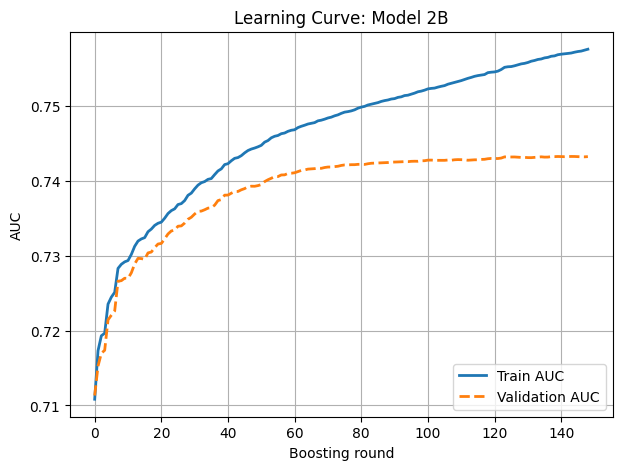

In [204]:
train_auc = evals_result_2B["train"]["auc"]
val_auc   = evals_result_2B["val"]["auc"]
rounds    = np.arange(len(train_auc))

# 2. Plot learning curves
plt.figure(figsize=(7, 5))
plt.plot(rounds, train_auc, label="Train AUC", linewidth=2)
plt.plot(rounds, val_auc,   label="Validation AUC", linewidth=2, linestyle="--")
plt.xlabel("Boosting round")
plt.ylabel("AUC")
plt.title("Learning Curve: Model 2B")
plt.legend(loc="lower right")
plt.grid(True)

# 3. Save figure locally
fig_path = path_figures + "learning_curve_model2B.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

In [205]:
num_rounds = len(evals_result_2B["train"]["auc"]) 
best_iteration = num_rounds - 1

train_auc = evals_result_2B["train"]["auc"][best_iteration]
val_auc = evals_result_2B["val"]["auc"][best_iteration]

print(train_auc)
print(val_auc)

0.7576155264088025
0.743261430696732


In [223]:
wandb.log({
    "train_auc": train_auc,
    "best_iteration": best_iteration,
    "val_auc":val_auc
})

In [224]:
wandb.log({"learning_curve": wandb.Image(fig_path)})

In [179]:
model_path = path_models+"model2B.ubj"
model2B.save_model(model_path)

In [180]:
# Create artifact
artifact = wandb.Artifact(
    name="xgboost_model2B",
    type="model",
    metadata={
        "description": "XGBoost Model 2B – includes categorical features",
        **best_params, 
        "best_auc_cv": float(best_auc),
        "best_round": int(best_iteration)
    }
)

artifact.add_file(model_path)
wandb.log_artifact(artifact)

<Artifact xgboost_model2B>

### figures

In [334]:
y_pred = model2B.predict(dval)

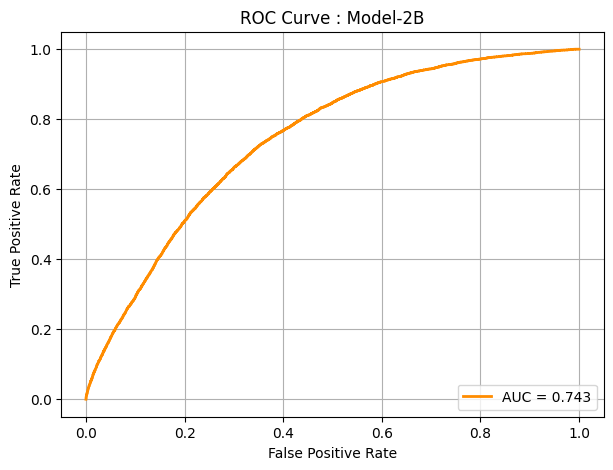

In [335]:
#Compute 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve : Model-2B')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(path_figures+"roc_model2B.png", dpi=300)
plt.show()

   percentile_bin  goal_rate  mean_prob  count  percentile_label
9               9   0.237156   0.235575   6287               100


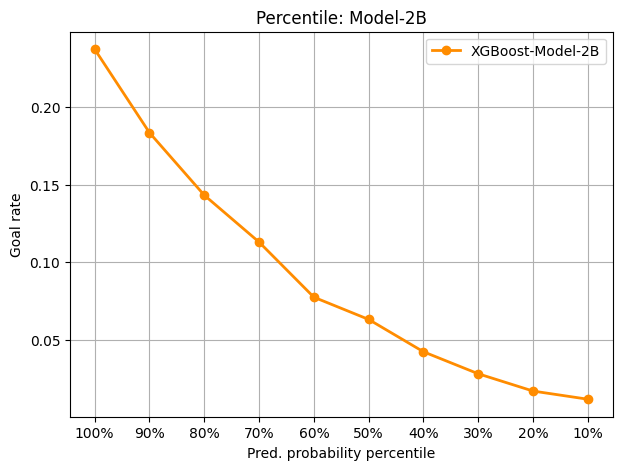

In [336]:
# Compute
df_val = pd.DataFrame({
    "y": np.asarray(y_val).ravel(),
    "p": y_pred

})

df_val["percentile_bin"] = pd.qcut(
    df_val["p"],
    q=10,                 
    labels=False
)

grouped = df_val.groupby("percentile_bin").agg(
    goal_rate=("y", "mean"),
    mean_prob=("p", "mean"),
    count=("y", "size")
).reset_index()

grouped["percentile_label"] = (grouped["percentile_bin"] + 1) * 10

# plot
plt.figure(figsize=(7, 5))
plt.plot(grouped["percentile_label"], grouped["goal_rate"],
         marker='o', color='darkorange', lw=2, label='XGBoost-Model-2B')
plt.xlabel("Pred. probability percentile")
plt.ylabel("Goal rate")
plt.title("Percentile: Model-2B")
plt.xticks(grouped["percentile_label"], [f"{x}%" for x in grouped["percentile_label"]])
plt.legend(loc='upper right')
plt.grid(True)
plt.gca().invert_xaxis()
print(grouped[grouped["percentile_bin"] == grouped["percentile_bin"].max()])
# Save
plt.savefig(path_figures + "percentile_model2B.png", dpi=300)

plt.show()

Slightly worse performance compared to model2A

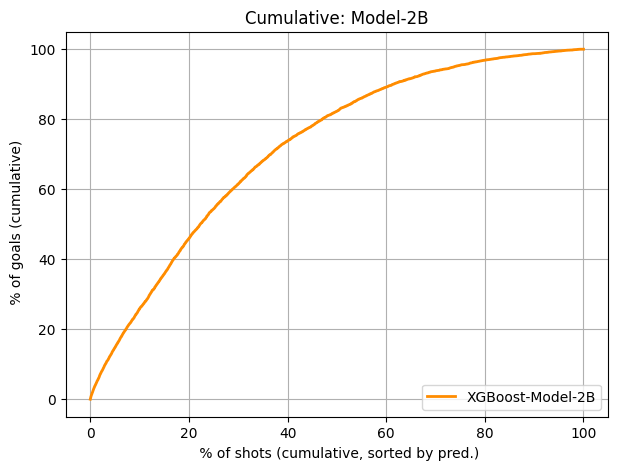

In [337]:
# compute
df_val = df_val.sort_values("p", ascending=False).reset_index(drop=True)
df_val["cum_shots"] = np.arange(1, len(df_val) + 1)
df_val["cum_goals"] = df_val["y"].cumsum()


df_val["cum_shots_pct"] = df_val["cum_shots"] / len(df_val)
df_val["cum_goals_pct"] = df_val["cum_goals"] / df_val["y"].sum()

# plot
plt.figure(figsize=(7, 5))

plt.plot(df_val["cum_shots_pct"] * 100, df_val["cum_goals_pct"] * 100,
         color='darkorange', lw=2, label='XGBoost-Model-2B')



plt.xlabel(" % of shots (cumulative, sorted by pred.)")
plt.ylabel(" % of goals (cumulative)")
plt.title("Cumulative: Model-2B")
plt.legend(loc='lower right')
plt.grid(True)

#save
plt.savefig(path_figures + "cumulative_model2B.png", dpi=300)

plt.show()

This is a slight improvement to model2A

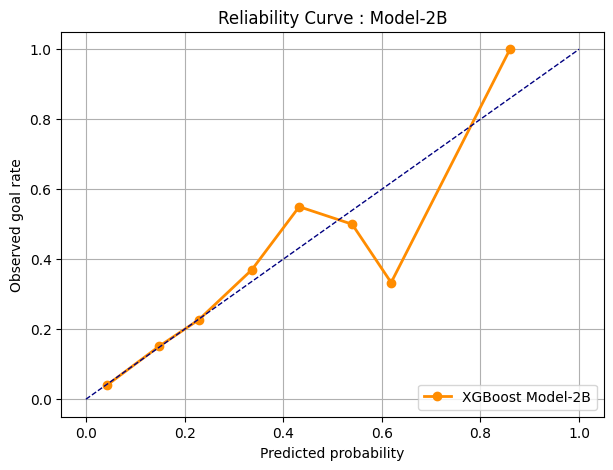

In [338]:
# compute
prob_true, prob_pred = calibration_curve(y_val, y_pred, n_bins=10)
#plot
plt.figure(figsize=(7, 5))
plt.plot(prob_pred, prob_true, marker='o', color='darkorange', lw=2, label='XGBoost Model-2B')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='')
plt.xlabel("Predicted probability")
plt.ylabel("Observed goal rate")
plt.title("Reliability Curve : Model-2B")
plt.legend(loc='lower right')
plt.grid(True)
# save
plt.savefig(path_figures + "calibration_model2B.png", dpi=300)

plt.show()

Here, model 2B performs worse compared to model 2A.

In [226]:
wandb.finish()

## Step 5.3

### information theory filtering

#### information gain

In [256]:
X = df_train[selected_features]
Y = df_train[["is_goal"]]

In [257]:
imputer = SimpleImputer(strategy="most_frequent")
X.loc[:, "rebound"] = imputer.fit_transform(X[["rebound"]])

imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

In [260]:
mi_scores = mutual_info_classif(X, Y.values.ravel(), random_state=42)

In [264]:
feature_cols = X.columns

mi_gain_df = pd.DataFrame({
    "feature": feature_cols,
    "mi_score": mi_scores
})
mi_gain_df = mi_gain_df.sort_values(by="mi_score", ascending=False).reset_index(drop=True)
mi_gain_df

,feature,mi_score
0,distance_from_net,0.024107
1,rebound,0.023004
2,period,0.021879
3,y_coord,0.019276
4,shot_angle,0.017409
5,x_coord,0.015553
6,last_event_distance,0.004991
7,event_speed,0.003574
8,last_event_x,0.003538
9,time_since_last_event,0.002954


In [265]:
f1 = "distance_from_net"
f2 = "x_coord"

mi_value = mutual_info_regression(
    X[[f1]],  # X must be 2D (feature matrix)
    X[f2],    # y must be 1D (target vector)
    random_state=42
)[0]

print(f"Mutual information between {f1} and {f2}: {mi_value:.4f}")

Mutual information between distance_from_net and x_coord: 4.4269


In [266]:
n_features = len(feature_cols)
mi_matrix = np.zeros((n_features, n_features))

for i, f1 in enumerate(feature_cols):
    for j, f2 in enumerate(feature_cols):
        if j <= i:
            continue  # skip self
        mi_value = mutual_info_regression(
            X[[f1]],   # 2D
            X[f2],     # 1D
            random_state=42
        )[0]
        mi_matrix[i, j] = mi_matrix[j, i] = mi_value

# turn into a DataFrame
mi_df = pd.DataFrame(mi_matrix, index=feature_cols, columns=feature_cols)

In [267]:
mi_df

,period_time_seconds,period,x_coord,y_coord,distance_from_net,shot_angle,last_event_x,time_since_last_event,last_event_distance,rebound,angle_change,event_speed
period_time_seconds,0.000000,0.057496,0.006613,0.004654,0.009043,0.006582,0.073926,0.093664,0.022508,0.006611,0.006478,0.048468
period,0.057496,0.000000,0.005708,0.007541,0.010792,0.007945,0.037951,0.040504,0.034022,0.000869,0.004147,0.064286
x_coord,0.006613,0.005708,0.000000,0.128235,4.427126,4.004067,0.017130,0.004986,0.376949,0.001134,0.027771,0.040675
y_coord,0.004654,0.007541,0.128235,0.000000,3.109503,2.818636,0.005964,0.007962,0.258240,0.000053,0.023631,0.026593
distance_from_net,0.009043,0.010792,4.427126,3.109503,0.000000,7.019193,0.013492,0.008861,0.621156,0.002139,0.026948,0.035046
shot_angle,0.006582,0.007945,4.004067,2.818636,7.019193,0.000000,0.011847,0.007716,0.522632,0.000830,0.086115,0.025341
last_event_x,0.073926,0.037951,0.017130,0.005964,0.013492,0.011847,0.000000,0.052156,0.337696,0.236295,0.487308,0.085565
time_since_last_event,0.093664,0.040504,0.004986,0.007962,0.008861,0.007716,0.052156,0.000000,0.023029,0.003828,0.006180,1.718200
last_event_distance,0.022508,0.034022,0.376949,0.258240,0.621156,0.522632,0.337696,0.023029,0.000000,0.046160,0.057015,4.472923
rebound,0.006611,0.000869,0.001134,0.000053,0.002139,0.000830,0.236295,0.003828,0.046160,0.000000,0.654856,0.023410


In [270]:
mask = np.triu(np.ones(mi_df.shape), k=1).astype(bool)
upper_tri = mi_df.where(mask)
stacked = upper_tri.stack()
redundant_pairs = stacked.reset_index()
redundant_pairs.columns = ["feature_1", "feature_2", "mi"]

In [271]:
redundant_pairs.sort_values("mi", ascending=False).head(15)

,feature_1,feature_2,mi
38,distance_from_net,shot_angle,7.019193
62,last_event_distance,event_speed,4.472923
22,x_coord,distance_from_net,4.427126
23,x_coord,shot_angle,4.004067
30,y_coord,distance_from_net,3.109503
31,y_coord,shot_angle,2.818636
59,time_since_last_event,event_speed,1.718200
63,rebound,angle_change,0.654856
41,distance_from_net,last_event_distance,0.621156
47,shot_angle,last_event_distance,0.522632


In [275]:
strong_features = ["distance_from_net", "rebound", "period", "last_event_distance"]

In [276]:
weak_features= ["angle_change", "time_since_last_event", "period_time_seconds", "last_event_x"]

In [277]:
redudant_features= ["y_coord", "x_coord"]

In [278]:
candidate_features = ["shot_angle", "event_speed"]

In [279]:
categorical_features= ["shot_type", "last_event_type"]

### forward wrapper

In [272]:
best_params = base_params.copy()
best_params.update({
    "max_depth": int(best_row_2B["max_depth"]),
    "eta": best_row_2B["eta"],
    "min_child_weight": best_row_2B["min_child_weight"],
    "subsample": best_row_2B["subsample"],
    "colsample_bytree": best_row_2B["colsample_bytree"]
})

best_num_boost_round = int(best_row_2B["best_round"])

In [273]:
def evaluate_features(feature_list, X_train, y_train, X_val, y_val, params, num_boost_round=100):
    
    dtrain = xgb.DMatrix(X_train[feature_list], label=y_train, enable_categorical=True)
    dval = xgb.DMatrix(X_val[feature_list], label=y_val, enable_categorical=True)
    
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        verbose_eval=False
    )
    
    preds = model.predict(dval)
    out = roc_auc_score(y_val, preds)
    return out

In [281]:
final_features=strong_features+["shot_angle","shot_type","period_time_seconds"]
print(final_features)

['distance_from_net', 'rebound', 'period', 'last_event_distance', 'shot_angle', 'shot_type', 'period_time_seconds']


In [282]:
X = df_train_filter[all_features]
Y = df_train_filter[["is_goal"]]

X_train, X_val, y_train, y_val = train_test_split(
    X,
    Y,
    test_size=0.2,      
    random_state=42
)

can_features = weak_features + candidate_features + categorical_features + redudant_features
can_features = [f for f in all_features if f not in final_features]
baseline_features = final_features

# -- Evaluate baseline ---------------------------------------------
best_auc = evaluate_features(baseline_features, X_train, y_train, X_val, y_val, best_params)
print(f"\nBaseline AUC (with {len(baseline_features)} features): {best_auc:.4f}\n")

# -- Evaluate each candidate --------------------------------------
results = []
for feat in can_features:
    test_features = strong_features + [feat]
    test_auc = evaluate_features(test_features, X_train, y_train, X_val, y_val, params)
    delta = test_auc - best_auc
    results.append((feat, test_auc, delta))
    sign = "+" if delta >= 0 else "-"
    print(f"Feature '{feat:20s}' → AUC = {test_auc:.4f} ({sign}{abs(delta):.4f})")

# -- Build results table ------------------------------------------
results_df = pd.DataFrame(results, columns=["feature", "val_auc", "delta"])
results_df.sort_values("delta", ascending=False, inplace=True)


Baseline AUC (with 7 features): 0.7409

Feature 'x_coord             ' → AUC = 0.7060 (-0.0349)
Feature 'y_coord             ' → AUC = 0.7161 (-0.0249)
Feature 'last_event_type     ' → AUC = 0.6858 (-0.0552)
Feature 'last_event_x        ' → AUC = 0.6863 (-0.0546)
Feature 'time_since_last_event' → AUC = 0.6876 (-0.0534)
Feature 'angle_change        ' → AUC = 0.6842 (-0.0568)
Feature 'event_speed         ' → AUC = 0.6880 (-0.0529)


### train model

In [339]:
X = df_train[final_features]
Y = df_train[["is_goal"]]

In [340]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    Y,
    test_size=0.2,      
    random_state=42
)

In [341]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True) 
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

In [286]:
max_depth_grid        = [4,5,6]
learning_rate_grid    = [0.05, 0.06, 0.08]
min_child_weight_grid = [1, 3, 5]
subsample_grid        = [1.0]
colsample_bytree_grid = [0.8]

In [287]:
results = [] 

for max_depth, eta, min_child_weight, subsample, colsample_bytree in itertools.product(
    max_depth_grid,
    learning_rate_grid,
    min_child_weight_grid,
    subsample_grid,
    colsample_bytree_grid
):
    params = base_params.copy()
    params.update({
        "max_depth": max_depth,
        "eta": eta,
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree
    })
    
    cv_result = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=200,       
        nfold=5,                   
        stratified=True,
        metrics="auc",
        early_stopping_rounds=20,
        seed=42,
        verbose_eval=False
    )
    
    # Best mean validation AUC and the iteration where it happened
    best_auc = cv_result["test-auc-mean"].max()
    best_round = cv_result["test-auc-mean"].idxmax()
    
    results.append({
        "max_depth": max_depth,
        "eta": eta,
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "best_auc": best_auc,
        "best_round": best_round
    })

# Collect everything
results_df = pd.DataFrame(results)

In [288]:
best_row_3 = results_df.loc[results_df["best_auc"].idxmax()]
print(best_row_3)

max_depth             6.000000
eta                   0.060000
min_child_weight      5.000000
subsample             1.000000
colsample_bytree      0.800000
best_auc              0.741156
best_round          155.000000
Name: 23, dtype: float64


For model3 we started from the previous known best parameters (for model 2B), and adjusted the grid. We run a two cross-validation adjusting the values and resulted in (max_depth=6, eta=0.06, min_child_weight=5, subsample=1, colsample_bytree=0.8) with an AUC of 0.741 (155 rounds).

In [289]:
best_params = base_params.copy()
best_params.update({
    "max_depth": int(best_row_3["max_depth"]),
    "eta": best_row_3["eta"],
    "min_child_weight": best_row_3["min_child_weight"],
    "subsample": best_row_3["subsample"],
    "colsample_bytree": best_row_3["colsample_bytree"]
})

best_num_boost_round = int(best_row_3["best_round"])

In [290]:
wandb.init(
    project="milestone_2", 
    name="xgb_model3",    
    config={
        "model": "XGBoost",
        "features": "final_features",
        **best_params
    }
)

In [291]:
evallist = [(dtrain, 'train'), (dval, 'val')]
evals_result_3 = {}

model3 = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=best_num_boost_round,
    evals=evallist,
    evals_result=evals_result_3,
    verbose_eval=False
)

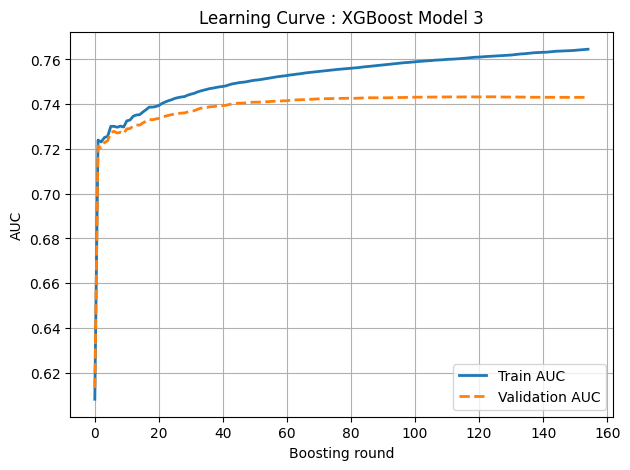

In [292]:
train_auc = evals_result_3["train"]["auc"]
val_auc   = evals_result_3["val"]["auc"]
rounds    = np.arange(len(train_auc))

# plot
plt.figure(figsize=(7, 5))
plt.plot(rounds, train_auc, label="Train AUC", linewidth=2)
plt.plot(rounds, val_auc,   label="Validation AUC", linewidth=2, linestyle="--")
plt.xlabel("Boosting round")
plt.ylabel("AUC")
plt.title("Learning Curve : XGBoost Model 3")
plt.legend(loc="lower right")
plt.grid(True)

# save
fig_path = path_figures + "learning_curve_model3.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

In [293]:
num_rounds = len(evals_result_3["train"]["auc"]) 
best_iteration = num_rounds - 1

train_auc = evals_result_3["train"]["auc"][best_iteration]
val_auc = evals_result_3["val"]["auc"][best_iteration]

print(train_auc)
print(val_auc)

0.7645558717930785
0.7430637315309849


In [294]:
wandb.log({
    "train_auc": train_auc,
    "best_iteration": best_iteration,
    "val_auc":val_auc
})
wandb.log({"learning_curve": wandb.Image(fig_path)})

In [295]:
model_path = path_models+"model3.ubj"
model3.save_model(model_path)

# Create artifact using values from best_params
artifact = wandb.Artifact(
    name="xgboost_model3",
    type="model",
    metadata={
        "description": "XGBoost Model 3 – final features",
        **best_params, 
        "best_auc_cv": float(best_auc),
        "best_round": int(best_iteration)
    }
)

artifact.add_file(model_path)
wandb.log_artifact(artifact)

<Artifact xgboost_model3>

### figures

In [342]:
y_pred = model3.predict(dval)

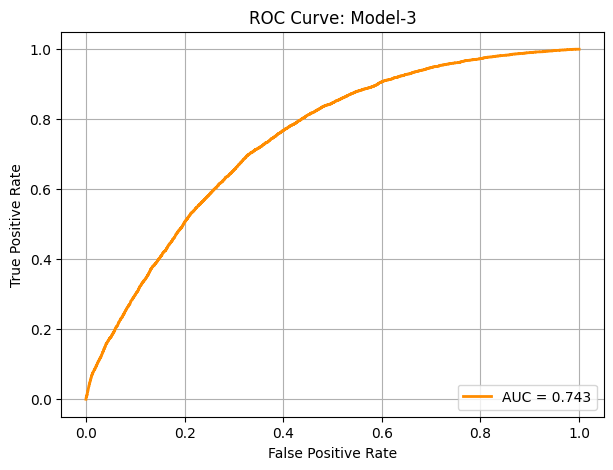

In [343]:
#Compute 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Model-3')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(path_figures+"roc_model3.png", dpi=300)
plt.show()

   percentile_bin  goal_rate  mean_prob  count  percentile_label
9               9   0.245143   0.248823   6331               100


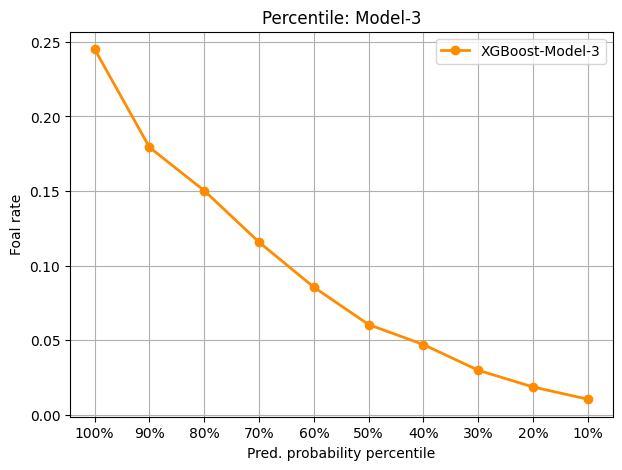

In [344]:
# compute
df_val = pd.DataFrame({
    "y": np.asarray(y_val).ravel(),
    "p": y_pred

})

df_val["percentile_bin"] = pd.qcut(
    df_val["p"],
    q=10,                 
    labels=False
)

grouped = df_val.groupby("percentile_bin").agg(
    goal_rate=("y", "mean"),
    mean_prob=("p", "mean"),
    count=("y", "size")
).reset_index()

grouped["percentile_label"] = (grouped["percentile_bin"] + 1) * 10

# plot
plt.figure(figsize=(7, 5))
plt.plot(grouped["percentile_label"], grouped["goal_rate"],
         marker='o', color='darkorange', lw=2, label='XGBoost-Model-3')
plt.xlabel("Pred. probability percentile")
plt.ylabel("Foal rate")
plt.title("Percentile: Model-3")
plt.xticks(grouped["percentile_label"], [f"{x}%" for x in grouped["percentile_label"]])
plt.legend(loc='upper right')
plt.grid(True)
print(grouped[grouped["percentile_bin"] == grouped["percentile_bin"].max()])
plt.gca().invert_xaxis()

# Save 
plt.savefig(path_figures + "percentile_model3.png", dpi=300)

plt.show()

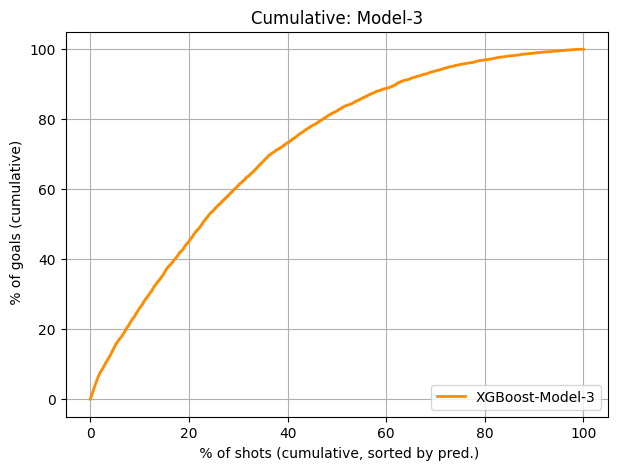

In [345]:
#compute
df_val = df_val.sort_values("p", ascending=False).reset_index(drop=True)
df_val["cum_shots"] = np.arange(1, len(df_val) + 1)
df_val["cum_goals"] = df_val["y"].cumsum()

df_val["cum_shots_pct"] = df_val["cum_shots"] / len(df_val)
df_val["cum_goals_pct"] = df_val["cum_goals"] / df_val["y"].sum()

# plot
plt.figure(figsize=(7, 5))


plt.plot(df_val["cum_shots_pct"] * 100, df_val["cum_goals_pct"] * 100,
         color='darkorange', lw=2, label='XGBoost-Model-3')

plt.xlabel(" % of shots (cumulative, sorted by pred.)")
plt.ylabel(" % of goals (cumulative)")
plt.title("Cumulative: Model-3")
plt.legend(loc='lower right')
plt.grid(True)

plt.savefig(path_figures + "cumulative_model3.png", dpi=300)

plt.show()

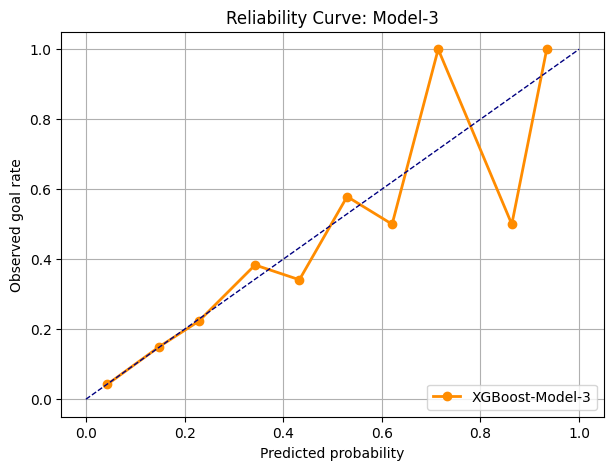

In [346]:
#compute
prob_true, prob_pred = calibration_curve(y_val, y_pred, n_bins=10)
#plot
plt.figure(figsize=(7, 5))
plt.plot(prob_pred, prob_true, marker='o', color='darkorange', lw=2, label='XGBoost-Model-3')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='')
plt.xlabel("Predicted probability")
plt.ylabel("Observed goal rate")
plt.title("Reliability Curve: Model-3")
plt.legend(loc='lower right')
plt.grid(True)
#save
plt.savefig(path_figures + "calibration_model3.png", dpi=300)

plt.show()

In [302]:
wandb.finish()

best_iteration,▁
train_auc,▁
val_auc,▁
best_iteration,154
train_auc,0.76456
val_auc,0.74306


### Disclaimer on the use of LLMs for coding
For the above script, GPT-5 was used on several occassions as a coding assistant. This help took three forms:

Documention on libraries and functions
Prompts were used to quickly obtain information on the arguments required for specific functions. This information is available within the libaries' documentation, but going through LLMs is faster. Example of such propmts are :
"I need store my model as an artifact in wandb. What arguments to use?" 

Specific instructions for challenging coding parts
When unable to proceed alone, I include the logic of what I wanted to achieve in a prompt, and adapted the code based on the response. For instance, in writing the function for wrapper, the part of the function that assignes evaluates the auc when adding/removing one features was written with the help of a prompt. No original idea was created by GPT 5 and we adapted the script so that we know what our code does and why.